# DeepCPunk

Este proyecto surge de la curiosidad por saber como será el futuro distópico que nos espera, lleno de neones, aires contaminados y alta tecnología.


<table>
    <tr>
        <td>
            <img src='images_notebook/portada.jpg'>
        </td>
        <td>
            <img src='images_notebook/cyberpunkScaled.jpg'>
        </td>
    </tr>
</table>

Dado que no sé nada de edición de imágenes tuve que buscar una solución distinta. No sé editar imágenes pero sé algo sobre las GANs... Solo tenía que hacer un set de datos de ciudades actuales, edificios normales, lo que vemos día a día... Por otro lado necesitamos tener una referencia de cómo creemos que será el futuro. Gracias a que es un género de moda hoy en día podemos encontrar cientos de fotos con la estética Cyberpunk en un momento.

Tras tener el data set simplemente tenía que decirle a la IA que quiero que me transforme las fotos de ciudades normales a ciudades futurísticas. Así que os voy a enseñar el proceso.

Todo el código de este notebook está basado en https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

# CycleGAN

En este notebook vamos a aprender en profundidad qué es una Cycle-Consistent Adversarial Nerwork (traducido en español sería algo así como "Red Adversarial Consistente en Ciclo").

Este tipo de red nos sirve para hacer **Traducción de Imagen a Imagen**. Esto quiere decir que transformamos una imagen(X) en otro tipo de imagen(Y), transformamos imágenes de un dominio a otro. Por ejemplo, una imagen en blanco y negro(X) a una foto de color(Y).

Una de las grandes ventajas de este tipo de redes es que no necesitan tener datos emparejados(a cada X le corresponde una Y concreta). Tener datos emparejados supone un problema, son más difíciles de generar y necesitas más cantidad. En nuestro caso con DeepCPunk requeríamos editar cada foto de ciudad y transformarla lo cual requeriría mucho tiempo o dinero.

¿Qué tenemos en vez de datos emparejados? Tenemos dos dominios de imágenes cada dominio con un estilo o características similares.
El dataset a usar tiene imágenes en el dominio de Ciudad(fotos de calles de ciudades sin editar con luz normal, ya sean día, noche, con lluvia, etc...). En el dominio tenemos imágenes con estilo Cyber Punk (colores neon, con zonas muy oscuras o luces muy saturadas...).



Hoy vamos a conseguir que que nuestra a red aprenda qué convierte una imagen en cyberpunk y viceversa.

La red va "buscando" qué transformaciones aplicar a una imagen para tranformarla en el tipo de imagen deseado.

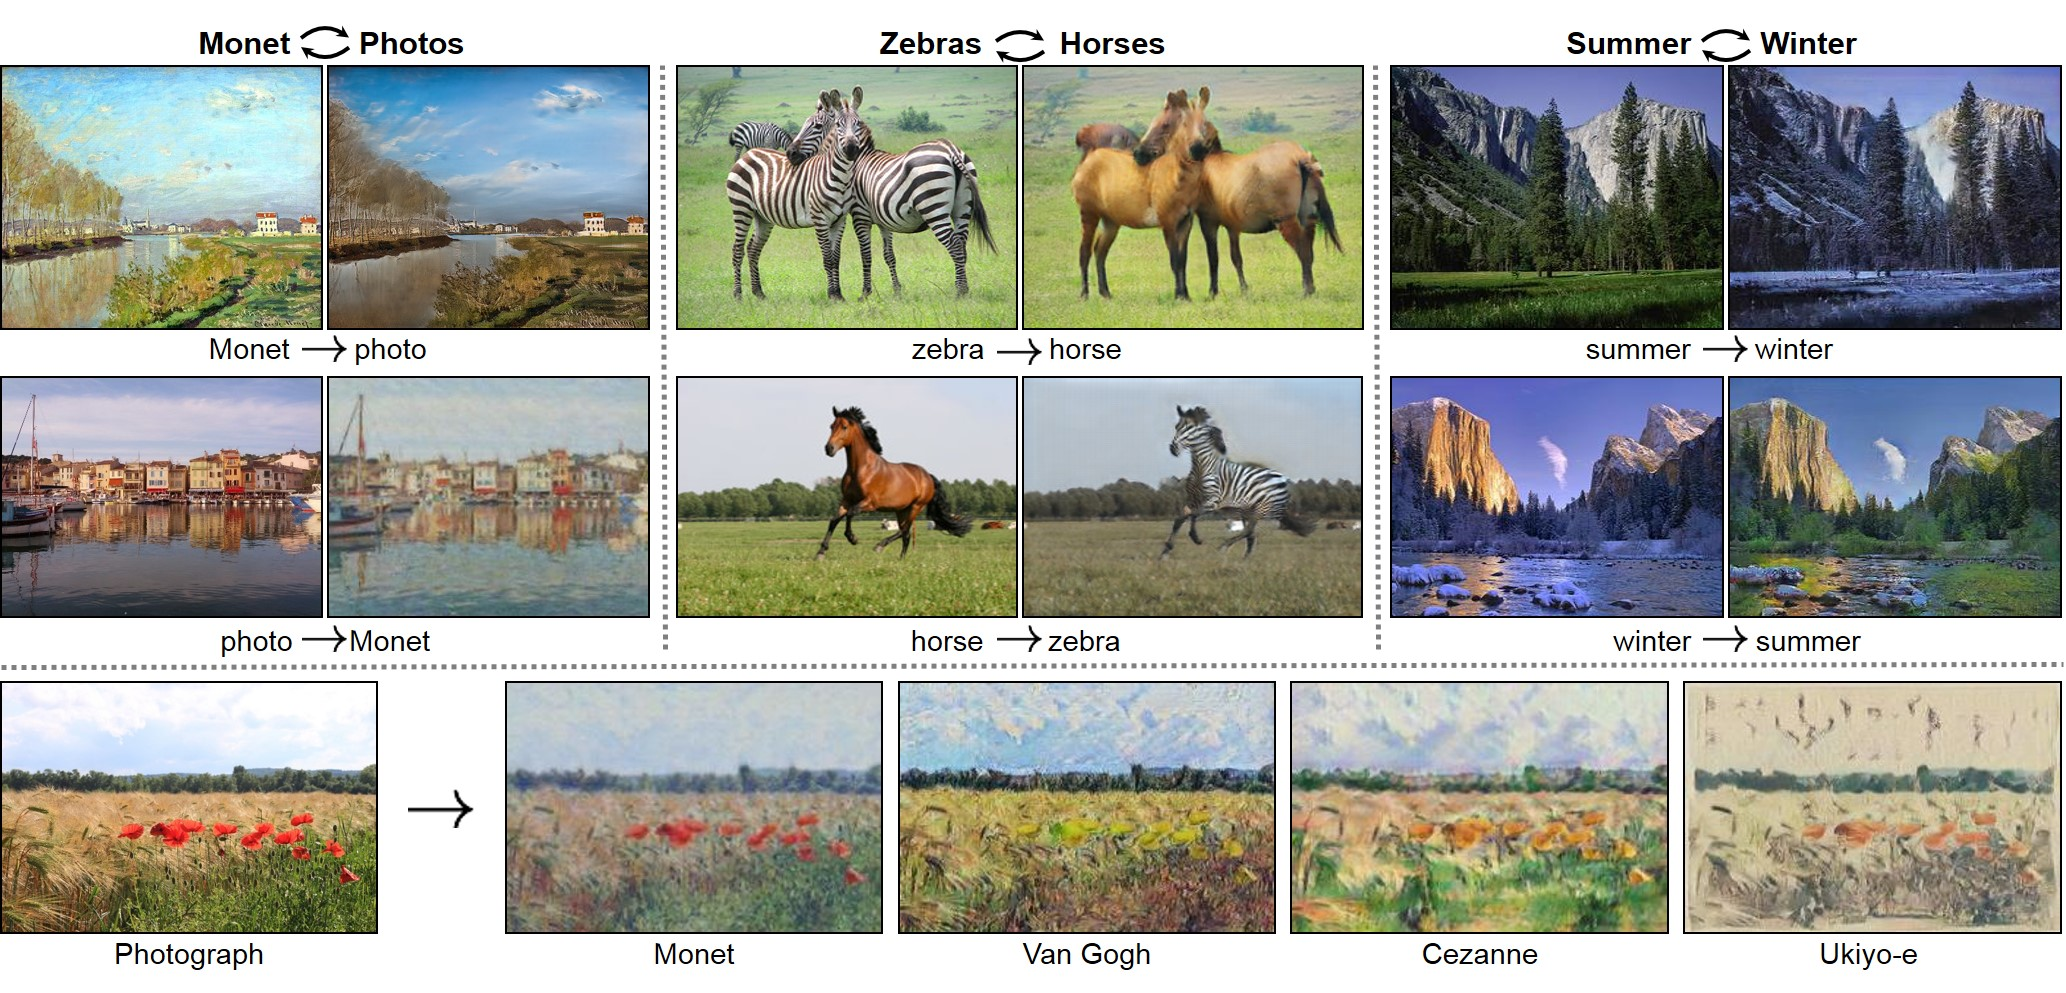

Para una explicación en profundidad podéis visualizar [este video](https://www.youtube.com/watch?v=ysEjAqnHp64).

Una CycleGAN se corresponde de 2 Generadores y 2 Discriminadores.

- Generador: El generador se encarga de sintetizar fotos.
- Discriminador: El discriminador se encarga de evaluar las imágenes generadas.

Ambos evolucionan durante el entrenamiento. El objetivo del generador es "engañar" al Discriminador por lo que va aprendiendo a generar mejor las fotos del dominio objetivo. Mientras el objetivo del Discriminador es aprender a distinguir entre imágenes sintéticas y reales.

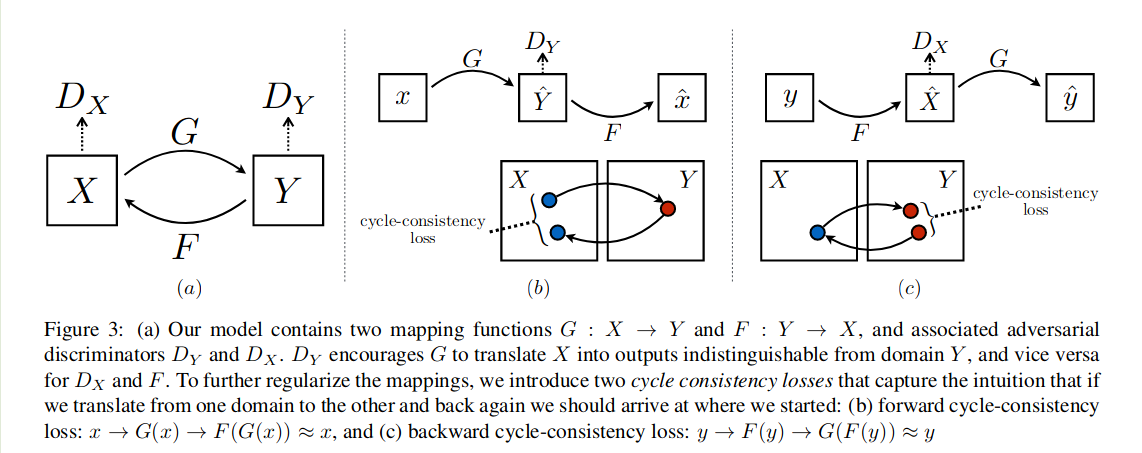

Dy hace que G transforme la entrada X en una salida indistinguible del dominio Y y viceversa para Dx y F.
La consistencia en ciclo evalua la capacidad de reverit un cambio en una imagen generada, la salida de G pasada por F debe ser similar a la imagen inicial. 

# Generador

Cycle-GAN se compone de **dos generadores** (y dos discriminadores que veremos posteriormente en detalle)

Nuestro Generador va a estar basado en un tipo de red llamada **autoencoder**. Este tipo de red tiene dos partes:
- **Codificador**: toma los datos más importantes de la imagen(aprende una representación).
- **Transformador**: extrae las carácterísticas que conformarán la imagen final.
- **Decodificador**: con esos datos codificados crea una nueva imagen.

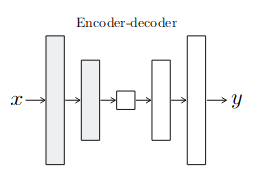

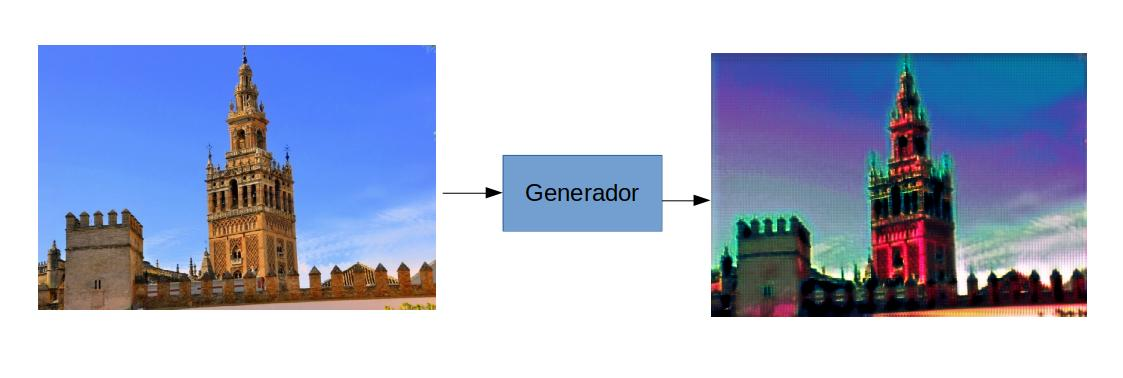

Para crear el Discriminador primero debemos crear una clase para ayudarnos a crear los bloques residuales destinados a crear la parte del transformador.

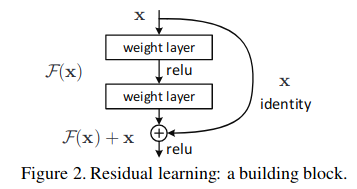

Los bloques residuales han demostrado ser una [mejora significativa en las redes convolucionales](https://arxiv.org/pdf/1512.03385.pdf).

In [ ]:
import torch
from torch.nn import init
import torch.nn as nn
import functools
import random
import itertools

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        
        Un bloque ResNet es un bloque convolucional con conexiones saltadas
        Construimos el bloque convolucional con build_conv_block() e implementamos
        las conexiones saltadas en forward().
        
        Paper original de Resnet https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


# Clase para definir el Generador:

In [ ]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=72, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=8, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- Nº de canales en las imágenes de entrada
            output_nc (int)     -- Nº de canales en las imágenes de salida
            ngf (int)           -- Nº de filtros en la última capa convolucional (last conv layer)
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 3
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()] # A causa de esta activación debemos reescalar las imágenes en [-1, 1]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

# Inicialización de pesos

La siguiente función auxiliar será usada para inicializar los pesos de la Red.
La inicialización de los pesos es una buena práctica a realizar en el Deep Learnig. 

Los pesos son los vectores que intervienen en las operaciones de las redes neuronales y configuran los distintos resultados.

La inicialización se realiza de tal forma que hará mas fácil la retropropagación(backpropagation) de los errores en la red. Por lo que la inicialización de los pesos usando una función en vez de forma aleatoria **acelera el proceso de entrenamiento** de la red.

In [ ]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net

# Image Pool

El motivo de usar un buffer de imágenes previamente generadas es la aceleración del entrenamiento.
Calcular el error para cada una de las imágenes generadas es costoso computacionalmente.

Si cada vez que calculamos el error usamos una imágen distinta no se tendría una referencia de "lo correcto" de forma constante, entonces nuestro objetivo de optimización variaría mucho.

Estrategia sacada de aquí https://arxiv.org/pdf/1612.07828.pdf


In [ ]:
class ImagePool():
    """This class implements an image buffer that stores previously generated images.
    Esta clase implementa un buffer de imágenes que almacena imagenes generadas previamente

    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    Este buffer nos permite actualizar los discriminadores usando un historial de imágenes
    generadas en vez de las generadas por los generadores más recientes
    """

    def __init__(self, pool_size):
        """Inicializa la clase ImagePool

        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Devuelve una imagen from the pool.

        Parameters:
            images: the latest generated images from the generator

        Returns images from the buffer.

        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images


# Discriminador

El discriminador es la parte de la red que determina cómo de bien lo está haciendo el generador.

El tipo de discriminador a usar es un discriminador PatchGAN. Se caracteriza por no tener una salida binaria sobre la autenticidad de la foto (falsa o real), en su lugar determina la autenticidad de la imagen por zonas(parches).

In [ ]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""
    # TODO CHECK IF n_layers=4 works fine
    def __init__(self, input_nc, ndf=64, n_layers=4, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

# Pérdidas

La función de abajo usa la pérdida logarítmica.
Si el discriminador lo hace bien tanto diferenciando sintéticas como reales resultara en un valor bajo de pérdida.

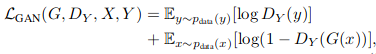

<img src="images_notebook/Log_loss_graph.png" width="400">

Lcyc evalúa con pérdida [L1](https://pytorch.org/docs/stable/nn.html#torch.nn.L1Loss) (mide la variación de la original y la que se transforma al dominio de la original en cada pixel)


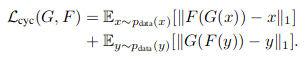

Así que la pérdida final resulta en la pérdida de ambos generadores + la pérdida del ciclo:
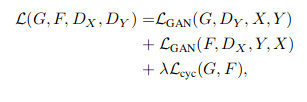

La optimización que haremos será para minimizar el error en el caso de los generadores(crear mejores imágenes y hacer bien el ciclo) y maximizarlo para los discriminadores(que no distingan las imágenes sinŧeticas de las reales)

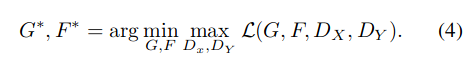

In [ ]:
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - tipo de objetivo de la GAN. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - etiqueta de una imagen verdadera
            target_fake_label (bool) - - etiqueta de una imagen falsa

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Crea un tensor etiqueta con la misma dimensión de la entrada

        Parameters:
            prediction (tensor) - - la predicción de un discriminador
            target_is_real (bool) - - si la etiqueta verdadera es verdadera o falsa

        Returns:
            Un tensor como etiqueta con los valores verdaderos con la dimensión de la entrada
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction) # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.expand_as

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


# CycleGAN completa

In [ ]:
class cycle_gan():

    def __init__(self, device='cpu', training=True):
        self.device = device
        use_dropout = False
        self.netG_A = init_net(ResnetGenerator(3, 3, 8, use_dropout=use_dropout, n_blocks=9), init_type='xavier').to(self.device)

        self.netG_B = init_net(ResnetGenerator(3, 3, 8, use_dropout=use_dropout, n_blocks=9), init_type='xavier').to(self.device)

        ndf = 64

        beta1 = 0.5
        self.training = training
        if training:
            self.netD_A = init_net(NLayerDiscriminator(3, ndf, n_layers=3).to(self.device))
            self.netD_B = init_net(NLayerDiscriminator(3, ndf, n_layers=3).to(self.device))
            self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()),
                                                lr=0.0002, betas=(beta1, 0.999))

        pool_size = 50
        self.fake_A_pool = ImagePool(pool_size)  # create image buffer to store previously generated images
        self.fake_B_pool = ImagePool(pool_size)  # create image buffer to store previously generated images
        # define loss functions
        self.criterionGAN = GANLoss('lsgan').to(self.device)  # define GAN loss.
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()
        # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.

        # https://discuss.pytorch.org/t/what-does-chain-in-itertools-do/1817
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()),
                                            lr=0.0002, betas=(beta1, 0.999))

    def set_input(self, A, B):
        """Tomamos las entradas a la red.

        Parameters:
            A (Tensor): Tensor con la imagen/es A.
            B (Tensor): Tensor con la imagen/es B.
        """

        self.real_A = A.to(self.device)
        self.real_B = B.to(self.device)

    def set_input_test(self, A):
        """Tomamos la entrada del dominio A.

        Parameters:
            A (Tensor): Tensor con la imagen/es A.
        """

        self.real_A = A.to(self.device)

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG_A(self.real_A)  # G_A(A)
        self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
        self.fake_A = self.netG_B(self.real_B)  # G_B(B)
        self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))

    def forward_test(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG_A(self.real_A)  # G_A(A)
        self.fake_A = self.netG_B(self.fake_B)


    def backward_D_basic(self, netD, real, fake):
        """Calculate GAN loss for the discriminator

        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator

        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        """Calculate the loss for generators G_A and G_B"""
        '''
            parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping. Setting 
            lambda_identity other than 0 has an effect of scaling the weight of the identity mapping loss. For example,
             if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss,
              please set lambda_identity = 0.1')

        '''
        #lambda_idt es la importancia dela pérdida del ciclo.
        lambda_idt = 0.5
        lambda_A = 10.0 # weight for cycle loss (A -> B -> A)
        lambda_B = 10.0 # weight for cycle loss (B -> A-> B)
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            self.idt_A = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            self.idt_B = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()


    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
        self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights

    def load_weights(self, dir, epoch):
        self.netG_A.load_state_dict(torch.load(dir + 'generatorA-{}.pkl'.format(epoch)))
        self.netG_B.load_state_dict(torch.load(dir + 'generatorB-{}.pkl'.format(epoch)))
        if self.training:
            self.netD_A.load_state_dict(torch.load(dir + 'discriminatorA-{}.pkl'.format(epoch)))
            self.netD_B.load_state_dict(torch.load(dir + 'discriminatorB-{}.pkl'.format(epoch)))

    def save_weights(self, dir, epoch):
        """
        Guarda los pesos de la red en el directorio indicado e incluyendo en el nombre la epoch
        """
        torch.save(self.netG_A.state_dict(), dir + 'generatorA-{}.pkl'.format(epoch))
        torch.save(self.netG_B.state_dict(), dir + 'generatorB-{}.pkl'.format(epoch))
        torch.save(self.netD_A.state_dict(), dir + 'discriminatorA-{}.pkl'.format(epoch))
        torch.save(self.netD_B.state_dict(), dir + 'discriminatorB-{}.pkl'.format(epoch))
    
    def print_losses(self):
        """
        Esta función la usamos para imprimir en la terminal las pérdidas
        """
        print('Generator losses: ', self.loss_G)
        print('Discriminator losses', self.loss_D_A, self.loss_D_B)

    def get_losses(self):
        """
        Returna la pérdida total de la GAN y de cada Discriminador
        """
        return self.loss_G, self.loss_D_A, self.loss_D_B

# Carga del dataset

El dataset lo he estructurado de tal manera que podremos cargarlo y dividirlo (en training y test) con las funciones de pytorch destinadas a ello.

Primero aplicamos unas [transformaciones](https://pytorch.org/docs/stable/torchvision/transforms.html) a las imágenes para ser entrenadas en nuestra red.

Para entrenar nuestro modelo tenemos la facilidad de usar los DataLoaders de PyTorch. Nos permiten agrupar en grupos(batches) y barajar los distintos datos para pasarselos a nuestro modelo. Gracias a ellos también evitamos cargar todo el dataset en la RAM lo cual en muchos casos resulta inviable.

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

BATCH_SIZE = 5
RESUME_TRAINING = False

transform = transforms.Compose([transforms.RandomCrop(600, pad_if_needed=True), 
                                transforms.Resize(512),
                                #transforms.Resize((720, 1024)),
                                transforms.ToTensor()])

transform_test = transforms.Compose([transforms.Resize((720, 1024)),
                                    transforms.ToTensor()])

def dataloader(direc, type):
    '''
    Returns dataloaders for training and testing from each domain
    :param direc: Directory of the datasets
    :param type: "City" or "CP" (CyberPunk)
    :return: Dataloader de entrenamiento y test
    '''
    image_path_train = direc + '/{}/'.format(type)
    image_path_test = direc + '/test_{}/'.format(type)
    
    train = ImageFolder(image_path_train, transform)
    test = ImageFolder(image_path_test, transform_test)
    
    train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test, batch_size=1, shuffle=False)
    return train_loader, test_loader

train_loader_x, test_loader_x = dataloader('./datasets/', 'City')
train_loader_y, test_loader_y = dataloader('./datasets/', 'CP')

# Escalado de imágenes

El escalado de las imágenes lo realizamos a causa de la función de activación* de la última capa del generador. 

Las imágenes generadas tendrán una escala \[-1, 1\] por lo que el generador recibirá imágenes en esta escala por lo que la entrada del primer ciclo debe estar en esta escala también (Si no tendríamos entradas irregulares de \[0,1\] y \[,-1, 1\]).

La función save_image() es usada para transformar la imagen de salida de la red a una escala convencional \[0, 255\] y poder guardarla.

*La función usada es tanh(x) (función tangente hiperbólica).

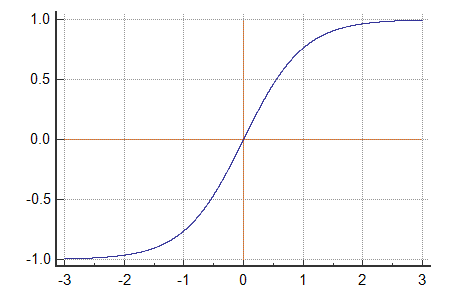

In [ ]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
       This function assumes that the input x is already scaled from 0-1.'''

    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x


def save_image(img_tensor, img_num, epoch, direc, tipo):
    '''
    Guarda una imagen con el número de la imagen y epoch en la que fue generada 
    '''
    img = img_tensor.squeeze(0) # Quita la dimensión de batch
    img = img.detach().cpu().numpy() # Pasa el array a la cpu y lo transforma a un array tipo numpy
    img = ((img + 1) * 255 / (2)).astype(np.uint8)
    img = img.transpose(1, 2, 0) # Pytorch tiene las imgs con los canales de color primero
                                 # lo común es \[altura, ancho, canales\]
    cv2.imwrite(direc + '/' + tipo + '-num-{}epoch-{}.png'.format(img_num, epoch), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


# Bucle de entrenamiento y test

El bucle itera un numero de veces(epochs, etapas) sobre el dataset. Cada cierto tiempo prueba el modelo sobre las imágenes de test y las guarda en la carpeta samples donde podremos ver los resultados.

In [ ]:
dir_weights = './model_weights/512_nueva_red/'

modelo = cycle_gan()
modelo.load_weights(dir_weights, 100)

# number of epochs to train the model
n_epochs = 10
TEST_CADA = 2

started = datetime.datetime.now()
print('Started at:', started)

for epoch in range(102, n_epochs + 1):
    # monitor training loss
    # TODO implementar el tracking de la pérdida
    train_gen_loss = 0.0
    train_dis_loss = 0.0

    start_time = time.time()
    
    print('Epoch número:', epoch)

    #####################
    # entrena el modelo #
    #####################
    for data_x, data_y in zip(train_loader_x, train_loader_y):
        modelo.set_input(scale(data_x[0]), scale(data_y[0])) # mete los datos en nuestra clase
        modelo.optimize_parameters() # realiza el proceso de forward, cálcuilo de pérdida
                                     # y retropropagación

    time_elapsed = time.time() - start_time
    print('Epoch {} took {:.2f} seconds ({:.2f} minutes)'.format(epoch, time_elapsed, time_elapsed/60))
    
    ####################
    # prueba el modelo #
    ####################
    if epoch % TEST_CADA == 0:
        modelo.print_losses()
        for num, batch in enumerate(test_loader_x):
            img, _ = batch
            modelo.set_input_test(scale(batch[0]))
            modelo.forward_test()

            save_image(modelo.fake_B, num, epoch, './samples/512/', 'B')
            save_image(modelo.fake_A, num, epoch, './samples/512/', 'A')

        modelo.save_weights(dir_weights, epoch)

print('Started at:', started)
print('Finished at ', datetime.datetime.now())